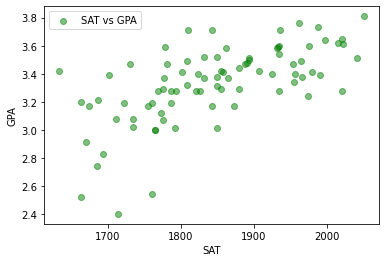

In [2]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

df = pd.read_csv('../data/sat_gpa.csv')

sat = df['SAT']
gpa = df['GPA']

plt.scatter(sat, gpa,c="g", alpha=0.5, label="SAT vs GPA")
plt.xlabel("SAT")
plt.ylabel("GPA")
plt.legend(loc='upper left')
plt.show()


In [67]:
def plot_losses(losses, min_y = None, max_y = None):
    plt.plot(losses, label="Loss (MSE)")
    plt.xlabel("iteration")
    plt.ylabel("MSE")
    if min_y is not None and max_y is not None:
        plt.ylim((min_y, max_y))
    plt.show()

In [88]:
import torch.nn

# convert data to tensors
y_data = torch.tensor(df['SAT'].values.reshape(-1,1), dtype=torch.float)
x_data = torch.tensor(df['GPA'].values.reshape(-1,1), dtype=torch.float)


# build model
model = torch.nn.Linear(1, 1)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) 

Final train loss: 6870.560


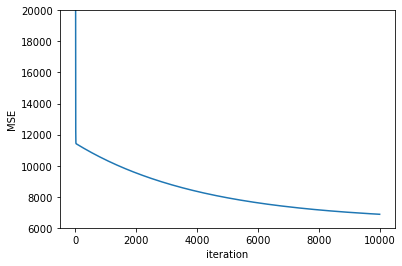

In [89]:
losses = []
num_epochs = 10_000

for i, epoch in enumerate(range(num_epochs)):
    model.train()
    optimizer.zero_grad()
    # Forward pass
    y_pred = model(x_data.float())
    # Compute Loss
    loss = criterion(y_pred.float(), y_data.float())
    losses.append(loss)
    # Backward pass
    loss.backward()
    optimizer.step()
    
    
print(f"Final train loss: {loss.item():.3f}")
plot_losses(losses, min_y=6_000, max_y=20_000)

## Normalizing tensors
The loss looks particularly large to us because the tensors are unnormalized, meaning they don't have small numerical values close to 0. So let's normalize them. Why do this and does it need to be done to the target? Discussion here: https://stats.stackexchange.com/questions/111467/is-it-necessary-to-scale-the-target-value-in-addition-to-scaling-features-for-re

We'll test out normalizing and reverting the normalizations. 

In [28]:
def normalize(data):
    return (data - data.mean()) / data.std()

def unnormalize(data, mean, std):
    return data * std + mean

def print_arr_stats(data):
    print(f"Tensor: {data.tolist()} Shape: {data.shape}\nMean: {data.mean().item()} Std: {data.std().item()}")

 # Let's test it out.
test_arr = torch.tensor([1, 2, 1, 2], dtype=torch.float)
test_arr_norm = normalize(test_arr)
test_arr_unnorm = unnormalize(test_arr_norm, test_arr.mean(), test_arr.std())

for arr in [test_arr, test_arr_norm, test_arr_unnorm]:
    print_arr_stats(arr)
    print("")

Tensor: [1.0, 2.0, 1.0, 2.0] Shape: torch.Size([4])
Mean: 1.5 Std: 0.5773502588272095

Tensor: [-0.866025447845459, 0.866025447845459, -0.866025447845459, 0.866025447845459] Shape: torch.Size([4])
Mean: 0.0 Std: 1.0

Tensor: [1.0, 2.0, 1.0, 2.0] Shape: torch.Size([4])
Mean: 1.5 Std: 0.5773502588272095



In [32]:
x_data_norm = normalize(x_data)
y_data_norm = normalize(y_data)

x_data_unnorm = unnormalize(x_data_norm, x_data.mean(), x_data.std())

# Print the first 3 to make sure it worked
list(zip(x_data, x_data_unnorm))[:3]

[(tensor([2.4000]), tensor([2.4000])),
 (tensor([2.5200]), tensor([2.5200])),
 (tensor([2.5400]), tensor([2.5400]))]

Train loss @ iter 20: 1.194
Train loss @ iter 40: 0.859
Train loss @ iter 60: 0.709
Train loss @ iter 80: 0.641
Train loss @ iter 100: 0.611
Train loss @ iter 120: 0.598
Train loss @ iter 140: 0.592
Train loss @ iter 160: 0.589
Train loss @ iter 180: 0.588


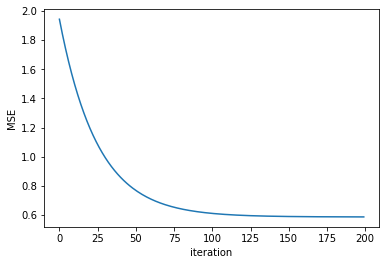

In [55]:
# Now let's train!

losses = []
num_epochs = 200
check_10_x = num_epochs/10

# Reset model and optimizer by recreating or we'll be fine tuning
model = torch.nn.Linear(1, 1)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) 

model.train()

for i, epoch in enumerate(range(num_epochs)):
    
    optimizer.zero_grad()
    
    y_pred = model(x_data_norm)
    
    loss = criterion(y_pred, y_data_norm)
    
    losses.append(loss)
    loss.backward()
    
    optimizer.step()
    
    if i > 0 and i % check_10_x == 0:
        print(f"Train loss @ iter {i}: {loss.item():.3f}")
        
plot_losses(losses)

## Messing around with learning rates
So why use 0.01 (1e-2)? Is it a magic number? Let's play with other learning rates to see how they do. To help us out, we'll abstract out the train loop. 

In [102]:
def train(lr, num_epochs=200):
    
    losses = []
    model = torch.nn.Linear(1, 1)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr) 
    
    model.train()

    for i, epoch in enumerate(range(num_epochs)):
        optimizer.zero_grad()
        y_pred = model(x_data_norm)
        loss = criterion(y_pred, y_data_norm)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

    return losses

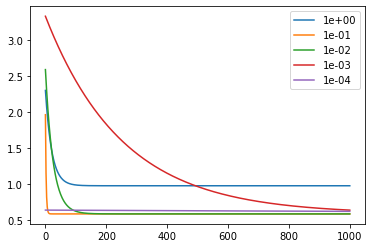

In [112]:
lrs = [1.0, 1e-1, 1e-2, 1e-3, 1e-4]
loss_lrs = [train(lr, num_epochs=1000) for lr in lrs] 

# Now let's plot.
for lr, lr_losses in zip(lrs, loss_lrs):
    plt.plot(lr_losses, label=f"{lr:.0e}")
plt.legend()
plt.show()

But which learning rate actually achieved the lowest train loss? **1e-2** 

Whoomp there it is!

In [113]:
lr_loss = list((f"{lr:.0e}", min(ll)) for (lr, ll) in zip(lrs, loss_lrs)) 
min_loss = min(lr_loss, key=lambda x: x[1])

print("Losses:")
print(lr_loss)
print("\nLowest loss:")
print(min_loss)

Losses:
[('1e+00', 0.9780021905899048), ('1e-01', 0.5869246125221252), ('1e-02', 0.5869245529174805), ('1e-03', 0.6395500302314758), ('1e-04', 0.6225765347480774)]

Lowest loss:
('1e-02', 0.5869245529174805)


In [38]:
new_x = torch.Tensor([[3.5]])
y_pred = model(new_x)



# print(y_pred)
# plt.scatter(gpa,sat, c="g", alpha=0.5, label="SAT vs GPA")
# plt.scatter(new_x.detach().numpy(),y_pred.detach().numpy(),  c="r")
# plt.xlabel("SAT")
# plt.ylabel("GPA")
# plt.legend(loc='upper left')
# plt.show()


In [39]:
# different ways to print weights (results) 

for name, param in model.named_parameters():
    if param.requires_grad:
        print (name, param.data)

for param in model.parameters():
    print(param.data)


# weight 
w= list(model.parameters())[0].data.numpy()[0]

# bias
b = list(model.parameters())[1].data.numpy()[0]

weight tensor([[451.3085]])
bias tensor([338.1691])
tensor([[451.3085]])
tensor([338.1691])


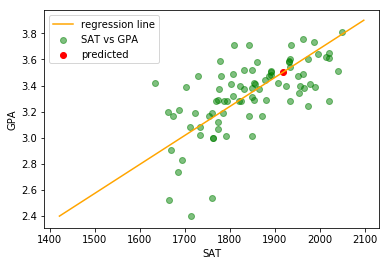

In [40]:
# creating line for y = w*x + b

xt = np.arange(2.4, 4, 0.1)
yt = [w * x + b for x in xt]


# prediction of y given x
new_x = torch.Tensor([[3.5]])
y_pred = model(new_x)


# graph raw data
plt.scatter(sat, gpa,c="g", alpha=0.5, label="SAT vs GPA")

# graph line
plt.plot(yt, xt, c="orange", label="regression line")

# graph predicted point
plt.scatter(y_pred.detach().numpy(), new_x.detach().numpy(), c="r", label="predicted")


plt.xlabel("SAT")
plt.ylabel("GPA")
plt.legend(loc='upper left')

plt.show()
